In [1]:
import os
import random
import itertools
import re

# 基本的なライブラリ
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats

# 描画ライブラリ
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn_analyzer import CustomPairPlot
import graphviz
import pydotplus
from IPython.display import Image
from IPython.display import HTML
from six import StringIO
from ipywidgets import interact, FloatSlider

# 前処理
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import VarianceThreshold

# 補完
from sklearn.experimental import (
    enable_iterative_imputer,
)  # IterativeImputerをimportするために必要
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer

# エンコード
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder

# データセット分割
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# 特徴量選択
from sklearn.feature_selection import (
    GenericUnivariateSelect,
    f_classif,
    mutual_info_classif,
    chi2,
)
from boruta import BorutaPy

# 学習中
from tqdm import tqdm
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings


# config python file
import config

SEED = config.SEED


from functions import *

fix_seed(SEED)


# 最大表示列数の指定（ここでは50列を指定）N
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 50)

%matplotlib inline

/Users/masanari/Library/CloudStorage/OneDrive-東京理科大学/projects/breast_cancer_analytics/notebooks/functions.py:278: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y: pd.Series(),


# データ読み込み

## 臨床データの読み込み

先に1.0-EDA_clinicalを実行すること

In [2]:
df_clinical = pd.read_pickle(config.INTERIM_PICKLE_EDA_DIR + "/df_clinical.pkl")
df_MB = pd.read_pickle(config.INTERIM_PICKLE_EDA_DIR + "/df_MB.pkl")
df_MTST = pd.read_pickle(config.INTERIM_PICKLE_EDA_DIR + "/df_MTST.pkl")

## 遺伝子データの読み込み

In [3]:
# cnaデータ
df_cna = pd.read_table(config.RAW_BRCA_METABRIC_DIR + "/data_cna.txt", index_col=0).T
df_cna = df_cna.drop(df_cna.index[0])

df_methylation_promoters_rrbs = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR + "/data_methylation_promoters_rrbs.txt", index_col=0
).T.sort_index()

# 遺伝子発現データ
# 生の遺伝子発現データ
df_mrna_agilent_microarray = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR + "/data_mrna_agilent_microarray.txt", index_col=0
).T
df_mrna_agilent_microarray = df_mrna_agilent_microarray.drop(
    "Entrez_Gene_Id"
).sort_index()
# zスコア化済み
df_mrna_agilent_microarray_zscores_ref_all_samples = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR
    + "/data_mrna_agilent_microarray_zscores_ref_all_samples.txt",
    index_col=0,
).T
df_mrna_agilent_microarray_zscores_ref_all_samples = (
    df_mrna_agilent_microarray_zscores_ref_all_samples.drop("Entrez_Gene_Id")
).sort_index()
# zスコア化（2倍体基準）済み
df_mrna_agilent_microarray_zscores_ref_diploid_samples = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR
    + "/data_mrna_agilent_microarray_zscores_ref_diploid_samples.txt",
    index_col=0,
).T
df_mrna_agilent_microarray_zscores_ref_diploid_samples = (
    df_mrna_agilent_microarray_zscores_ref_diploid_samples.drop("Entrez_Gene_Id")
).sort_index()

# 　ファイルの中身が壊れているため、使用するなら要修正
# df_mutations = pd.read_table(config.RAW_BRCA_METABRIC_DIR + "/data_mutations.txt").T


# 各dfの中身変更防止の為setを仕様
df_set = (
    df_cna,
    df_methylation_promoters_rrbs,
    df_mrna_agilent_microarray_zscores_ref_all_samples,
    df_mrna_agilent_microarray_zscores_ref_diploid_samples,
    df_mrna_agilent_microarray,
    # df_mutations
)
df_name_set = (
    "df_cna",
    "df_methylation_promoters_rrbs",
    "df_mrna_agilent_microarray_zscores_ref_all_samples",
    "df_mrna_agilent_microarray",
    # "df_mutations"
)

# 目的変数の生成

元のdfにはない目的変数カラム（5年後の生存の有無）を生成する。

## 目的変数｜5,10,15年後の予後の2値分類
5,10,15年後の予後を2値分類する。  
そのためにVITAL_STATUSとOS_MONTHを利用する。  
以下のフローチャートで生成する。  

In [4]:
HTML(
    '<div class="mxgraph" style="max-width:100%;border:1px solid transparent;" data-mxgraph="{&quot;highlight&quot;:&quot;#0000ff&quot;,&quot;nav&quot;:true,&quot;resize&quot;:true,&quot;toolbar&quot;:&quot;zoom layers tags lightbox&quot;,&quot;edit&quot;:&quot;_blank&quot;,&quot;xml&quot;:&quot;&lt;mxfile host=\&quot;Electron\&quot; modified=\&quot;2022-05-01T07:33:42.0.405Z\&quot; agent=\&quot;5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) draw.io/17.2.0.2 Chrome/100.0.4896.60 Electron/18.0.1 Safari/537.36\&quot; etag=\&quot;CUa6MuG2A-EYqdbBh0ys\&quot; version=\&quot;17.2.0.2\&quot; type=\&quot;device\&quot;&gt;&lt;diagram id=\&quot;C5RBs43oDa-KdzZeNtuy\&quot; name=\&quot;Page-1\&quot;&gt;7VhZc5swEP41TJ7a4Yix/RjbcZI2SduBJNOnjAIyqBasK4SP/vpKQTIQXB9tncMTP3jYZVlJ+317gOH0k/kZQ5P4CkJMDdsM54YzMGy7ZZniXyoWhcLtOoUiYiQsVFap8MgvrJTquSgnIc5qhhyAcjKpKwNIUxzwmg4xBrO62QhofdUJinBD4QWINrV3JORxoe3Y7VJ/jkkU65Utt1vcSZA2VifJYhTCrKJyTg2nzwB4cZXM+5jK2Om43F0s7ujl2D379C37iW56n/3r2w+Fs+EujyyPwHDK/69ru3A9RTRX8VJn5QsdQAZ5GmLpxDScXswTKi4tcfkDc75QgKOcg1AB4zFEkCJ6CTBRdiNIuTKzpIzT8EQCK+QHCsG4UA0JpWoNISn7jpAyzmC8xE46WAIhjSl6wLSHgnH0uNE+UGDiVgoplq5CQQZ1lnJzp6W2t2VsFQYZ5CzAa+xUcnDEIrzOn1vYyf1VeKqQO8OQYM4WwoBhijiZ1smMVE5ES7sSd3GhoN+BBk6DBuHIaPVuL/yTy3vPP/FvPMMWrs0v3v3Vl2v/3DNagzVMkSjNYsKxN0GP4ZqJ2lJnT5UV4uC9iKIsU5hugHw3yKaYcTxfG2R911WZrkpdR4mzsm5YuhjElZpxbO4JluMGLN9FKX1P0H9JUHfLBNX9a2OGKrJoYmydsMrTVyDiXKUJjEaZ2NhT6iwX/Hs2tRpsuoYGmTbj8abp9kJkau/GJevVc8ltcKnsDDITXJTIek+5jLm8b+raWi1cMSQPeba5V9QAlvQZooRQGaxzTKeYkwCt6CiIkigVQiCwxmw1c8SSJI2E5JaS/8hUUXz32Gna9U6zlKutxlzRajr7ajXt1ROAYrZs9maB4xDRDB9c63fsJ4B0X7r3d7ap1m+6Fj9769dldXPvt7as14o95kdH/GoEev3jQHer4fJ9HtgPw+xDmwj0Dit8qr8+qv5xNCCCLLYJI/E3IBlGGT56Hw3+OBrYqzrRs44GuhpWZwMmAnFoM8DT1/9j56VnAF0lNk9lPssPfyhzrP0BIsTyS25RE8vP4c7pbw==&lt;/diagram&gt;&lt;/mxfile&gt;&quot;}"></div><script type="text/javascript" src="https://viewer.diagrams.net/js/viewer-static.min.js"></script>'
)

In [5]:
def make_target(df: pd.DataFrame(), year: int = 5, drop=False):
    df = df.copy()  # 引数dfの更新を防ぐ（pythonの関数は参照渡し）
    target_name = "OS_{0}years".format(str(year).zfill(2))
    df[target_name] = np.nan
    df[target_name] = df[target_name].mask(df["OS_MONTHS"] > year * 12, False)
    df[target_name] = df[target_name].mask(
        (df["OS_MONTHS"] <= year * 12) & (df["VITAL_STATUS"] == "Died of Disease"),
        True,
    )
    # targetを定義できなかったデータは除く
    if drop:
        df = df[df[target_name].notnull()]
    return df

In [6]:
df_MB = make_target(df_MB, year=5)
df_MB = make_target(df_MB, year=10)
df_MB = make_target(df_MB, year=15)
target_list = ["OS_05years", "OS_10years", "OS_15years"]

# データフレームの結合

臨床データと遺伝子データを結合する  
結合パターン
1. 臨床データと生の遺伝子発現データ
2. 臨床データとzスコア化した遺伝子発現データ
3. 臨床データとzスコア化（2倍体）した遺伝子発現データ


## データフレームの結合
### 使用する特徴量

臨床データ
- 目的変数：OS_nyears
- 遺伝子学的特徴量：CLAUDIN_SUBTYPE

遺伝子発現データ
- 全ての遺伝子発現

In [7]:
df_cross = (
    pd.merge(
        df_MB[
            ["PATIENT_ID", "OS_05years", "OS_10years", "OS_15years", "CLAUDIN_SUBTYPE"]
        ],
        df_mrna_agilent_microarray,
        left_on="PATIENT_ID",
        right_index=True,
        how="inner",
    )
    .reset_index(drop=True)
    .drop("PATIENT_ID", axis=1)
)
df_cross.tail()

,OS_05years,OS_10years,OS_15years,CLAUDIN_SUBTYPE,RERE,RNF165,CD049690,BC033982,PHF7,CIDEA,PAPD4,AI082173,SLC17A3,SDS,ATP6V1C2,F3,FAM71C,AK055082,BU687559,LIN52,PCOTH,GRM1,FXN,SLC9A1,PML,...,TMEM146,SLIT3-AS1,PSMC3IP,TEAD1,LOC253724,BM725158,GRHPR,EGLN2,TBC1D4,ANGPTL2,AF086457,AK124197,ENOX1,SBF2-AS1,VN1R4,BX115874,BX107598,UGCGL1,VPS72,CSMD3,CC2D1A,CB986545,IGSF9,DA110839,FAM71A
1899,False,False,False,LumA,8.589374,6.002483,5.116077,4.996112,5.802742,5.474550,8.251690,5.373561,5.546402,6.532649,5.535139,6.282020,5.440358,5.637957,5.172188,6.486128,6.074573,5.281556,6.058330,8.722802,5.891944,...,5.394435,5.324246,6.132406,5.471503,5.372043,5.364380,8.455392,10.303605,6.686198,9.987552,5.354638,5.529167,5.722099,5.240904,5.521765,5.488675,5.461927,7.536208,8.314500,5.337300,6.278034,5.426899,6.923887,5.251896,5.168953
1900,True,True,True,LumB,8.402660,6.104059,5.443955,5.224513,5.256086,6.659117,8.641838,5.488370,5.522964,7.102716,5.353956,5.546199,5.289827,5.272168,5.424468,6.491748,5.865518,5.564988,6.132467,8.814733,6.236368,...,5.304696,5.396539,6.221306,5.315972,5.300309,5.268524,8.523291,11.353435,6.623708,8.441388,5.443857,5.644035,5.453321,5.171671,5.441341,5.375910,5.393811,7.709596,8.105717,5.397931,6.325456,5.217163,6.524268,5.505418,5.252479
1901,False,False,True,LumB,8.236918,5.402870,5.533742,5.468793,5.571897,5.439574,8.979375,5.283460,5.804127,6.593890,5.353883,5.705768,5.531300,5.313886,5.212158,6.906297,6.116738,5.132988,6.031882,8.530870,5.744546,...,5.466731,5.291783,7.066555,5.382979,5.550651,5.335161,8.286103,10.428968,6.769603,6.564861,5.591439,5.597712,5.334787,5.182920,5.339665,5.487068,5.406575,7.729912,7.944622,5.412713,6.254337,5.405552,6.121864,5.462270,5.357823
1902,False,NaN,NaN,LumB,8.376571,5.617954,5.375647,5.305559,5.631592,5.734358,8.628511,5.232599,5.472525,6.175189,5.473054,5.963092,5.308848,5.491198,5.050838,6.507257,5.484692,5.355723,6.003971,9.396055,5.921776,...,5.294014,5.389626,6.250953,5.489047,5.725481,5.382300,8.473675,10.452393,6.571327,7.323750,5.334621,5.560818,5.406241,5.351516,5.361063,5.214711,5.689935,7.329023,8.348807,5.474224,6.415853,5.344851,7.029076,5.519022,5.512290
1903,False,False,False,LumB,9.283964,7.137196,5.221194,5.549350,5.462977,5.222914,8.251690,5.365380,5.660058,6.683335,5.327812,5.818325,5.066311,5.361826,5.256033,6.292127,5.387614,5.342313,5.983110,8.883370,6.408964,...,5.281974,5.253435,6.125892,5.466416,5.467026,5.384024,8.202645,10.394254,6.886155,8.423223,5.312663,5.772291,5.646755,5.479193,5.709304,5.227597,5.382574,7.763496,8.053959,5.238813,6.898575,5.353198,6.769960,5.464610,5.232599


### 重複カラムのリネーム
有識者の意見：重複した遺伝子発現は別の遺伝子発現として扱うべき。


In [8]:
# 重複特徴量の確認
print("重複特徴量")
print(df_cross.columns[df_cross.columns.duplicated()].value_counts())
# 重複特徴量のrename
df_cross = rename_duplicated_columns(df_cross)
# 重複特徴量の確認
print("重複特徴量（rename後確認）")
print(df_cross.columns[df_cross.columns.duplicated()].value_counts())

重複特徴量
TRDV2        6
RPL13A       5
IL23A        4
WASH3P       3
LINC00965    2
            ..
LSP1         1
CLK2         1
TNRC18       1
KPNA2        1
C4orf50      1
Length: 168, dtype: int64
重複特徴量（rename後確認）
Series([], dtype: int64)


# 欠損値データの処理

### OS_05yearsが欠損しているデータの削除

In [9]:
df_cross = df_cross[df_cross["OS_05years"].notnull()]
df_cross.shape

(1757, 24372)

### 遺伝子発現の欠損値の確認

In [10]:
df_tmp = df_cross.isnull().sum().sort_values()[::-1]
df_tmp = df_tmp[df_tmp.values > 0]

In [11]:
display(
    df_cross[df_cross["SLC25A19"].isnull()],
    df_cross[df_cross["CSNK2A1"].isnull()],
    df_cross[df_cross["AK127905"].isnull()],
    df_cross[df_cross["TMPRSS7"].isnull()],
    df_cross[df_cross["IDO1"].isnull()],
    df_cross[df_cross["BAMBI"].isnull()],
    df_cross[df_cross["FAM71A"].isnull()],
)

,OS_05years,OS_10years,OS_15years,CLAUDIN_SUBTYPE,RERE,RNF165,CD049690,BC033982,PHF7,CIDEA,PAPD4,AI082173,SLC17A3,SDS,ATP6V1C2,F3,FAM71C,AK055082,BU687559,LIN52,PCOTH,GRM1,FXN,SLC9A1,PML,...,TMEM146,SLIT3-AS1,PSMC3IP,TEAD1,LOC253724,BM725158,GRHPR,EGLN2,TBC1D4,ANGPTL2,AF086457,AK124197,ENOX1,SBF2-AS1,VN1R4,BX115874,BX107598,UGCGL1,VPS72,CSMD3,CC2D1A,CB986545,IGSF9,DA110839,FAM71A
486,False,False,False,LumA,8.752832,6.728878,5.265908,5.428122,6.011156,8.695291,8.466168,5.267247,5.407875,5.680328,5.418472,6.566780,5.445005,5.338215,5.158566,5.980846,5.835921,5.387767,6.127834,9.070367,6.116849,...,5.421358,5.427568,5.731478,5.259431,5.285398,5.191198,8.241863,10.777161,6.990013,8.236918,5.288145,5.567312,5.562634,5.549441,5.613648,5.697380,5.561457,6.658756,8.767993,5.182273,6.511633,5.256083,7.874376,5.462590,5.236271
1651,False,False,NaN,Her2,8.298668,6.186827,5.266570,5.254843,6.242823,5.522508,8.389472,4.998942,5.611558,6.211793,5.551609,5.234407,5.509162,5.590460,5.248835,6.445314,7.308816,5.385550,6.218572,9.087248,6.282904,...,5.248726,5.384832,6.912935,5.548605,5.337198,5.397305,7.924804,10.507321,6.556178,7.054271,5.471377,6.337595,5.696034,5.612112,5.294910,5.132331,5.291950,7.248749,8.705246,5.539829,6.291565,5.464605,7.602547,5.368716,5.316522


,OS_05years,OS_10years,OS_15years,CLAUDIN_SUBTYPE,RERE,RNF165,CD049690,BC033982,PHF7,CIDEA,PAPD4,AI082173,SLC17A3,SDS,ATP6V1C2,F3,FAM71C,AK055082,BU687559,LIN52,PCOTH,GRM1,FXN,SLC9A1,PML,...,TMEM146,SLIT3-AS1,PSMC3IP,TEAD1,LOC253724,BM725158,GRHPR,EGLN2,TBC1D4,ANGPTL2,AF086457,AK124197,ENOX1,SBF2-AS1,VN1R4,BX115874,BX107598,UGCGL1,VPS72,CSMD3,CC2D1A,CB986545,IGSF9,DA110839,FAM71A
718,False,False,False,Her2,8.983845,6.154832,5.463275,5.140800,5.762100,5.575108,8.366148,5.213441,5.480032,6.094584,5.539119,5.995259,5.490708,5.525184,5.517009,6.715420,5.626920,5.271677,6.252703,9.599483,6.219926,...,5.163662,5.487514,6.888481,5.603110,5.407872,5.257659,7.535728,11.197757,6.335867,8.407267,5.473802,5.976417,5.230611,5.393206,5.589352,5.262591,5.499623,7.690986,8.334724,5.433179,6.366907,5.374074,6.276341,5.233092,5.127081
1658,False,NaN,NaN,LumB,8.809021,6.490103,5.502013,5.716855,5.671855,5.315538,8.387535,5.711542,5.535965,7.798269,5.490895,5.672131,5.408700,5.338358,5.129173,5.878103,6.915673,5.466695,5.711715,8.630528,6.869970,...,5.242368,5.276341,6.309263,5.618022,5.406522,5.197122,7.924265,10.707883,6.680489,7.651638,5.197415,6.425573,5.474114,5.481945,5.467659,5.644017,5.478255,7.114368,8.847109,5.222065,6.350829,5.286291,6.608030,5.476758,5.570788


,OS_05years,OS_10years,OS_15years,CLAUDIN_SUBTYPE,RERE,RNF165,CD049690,BC033982,PHF7,CIDEA,PAPD4,AI082173,SLC17A3,SDS,ATP6V1C2,F3,FAM71C,AK055082,BU687559,LIN52,PCOTH,GRM1,FXN,SLC9A1,PML,...,TMEM146,SLIT3-AS1,PSMC3IP,TEAD1,LOC253724,BM725158,GRHPR,EGLN2,TBC1D4,ANGPTL2,AF086457,AK124197,ENOX1,SBF2-AS1,VN1R4,BX115874,BX107598,UGCGL1,VPS72,CSMD3,CC2D1A,CB986545,IGSF9,DA110839,FAM71A
7,False,NaN,NaN,claudin-low,8.436053,5.845972,5.429151,5.462739,5.796744,9.513015,8.955945,5.270376,5.566713,6.258003,5.27322,7.257667,5.299815,5.328303,5.370871,6.250129,5.567929,5.617658,5.666111,7.281997,6.237218,...,5.335976,5.480618,5.675537,5.56352,5.420137,5.335642,7.826649,9.959284,7.298256,7.765512,5.594321,5.681154,5.687635,5.496705,5.256771,5.528183,5.556035,7.311774,7.506798,5.336678,6.040794,5.069086,5.909208,5.447886,5.493015


,OS_05years,OS_10years,OS_15years,CLAUDIN_SUBTYPE,RERE,RNF165,CD049690,BC033982,PHF7,CIDEA,PAPD4,AI082173,SLC17A3,SDS,ATP6V1C2,F3,FAM71C,AK055082,BU687559,LIN52,PCOTH,GRM1,FXN,SLC9A1,PML,...,TMEM146,SLIT3-AS1,PSMC3IP,TEAD1,LOC253724,BM725158,GRHPR,EGLN2,TBC1D4,ANGPTL2,AF086457,AK124197,ENOX1,SBF2-AS1,VN1R4,BX115874,BX107598,UGCGL1,VPS72,CSMD3,CC2D1A,CB986545,IGSF9,DA110839,FAM71A
140,False,True,True,claudin-low,8.721524,5.500859,5.521834,5.236688,5.533894,6.683335,7.50078,5.202739,5.722302,7.988028,6.182807,5.668817,5.382574,5.202969,5.139063,5.961513,5.551212,5.153493,6.379514,9.508277,6.140016,...,5.177635,5.20413,6.162613,5.48822,5.461181,5.252583,7.521205,10.118382,6.49044,10.160884,5.341439,5.910113,5.622522,5.501713,5.565144,5.740884,5.074019,7.725871,8.411298,6.090043,6.20853,5.180896,7.442164,5.326259,5.309085


,OS_05years,OS_10years,OS_15years,CLAUDIN_SUBTYPE,RERE,RNF165,CD049690,BC033982,PHF7,CIDEA,PAPD4,AI082173,SLC17A3,SDS,ATP6V1C2,F3,FAM71C,AK055082,BU687559,LIN52,PCOTH,GRM1,FXN,SLC9A1,PML,...,TMEM146,SLIT3-AS1,PSMC3IP,TEAD1,LOC253724,BM725158,GRHPR,EGLN2,TBC1D4,ANGPTL2,AF086457,AK124197,ENOX1,SBF2-AS1,VN1R4,BX115874,BX107598,UGCGL1,VPS72,CSMD3,CC2D1A,CB986545,IGSF9,DA110839,FAM71A
1814,False,False,NaN,LumA,9.208431,6.120859,5.480815,5.094417,5.885308,6.954527,8.813915,5.171671,5.57697,6.018173,5.481612,6.282845,5.274408,5.491235,5.185381,6.833276,5.79483,5.296329,6.129174,9.220519,6.635205,...,5.335236,5.583297,6.12615,4.905798,5.266572,5.716686,8.333421,10.532636,7.14226,7.432982,5.474933,6.171326,5.616832,5.669589,5.446446,5.660212,5.578895,6.88075,7.749458,5.380891,6.092204,5.548796,6.204183,5.376818,5.101745


,OS_05years,OS_10years,OS_15years,CLAUDIN_SUBTYPE,RERE,RNF165,CD049690,BC033982,PHF7,CIDEA,PAPD4,AI082173,SLC17A3,SDS,ATP6V1C2,F3,FAM71C,AK055082,BU687559,LIN52,PCOTH,GRM1,FXN,SLC9A1,PML,...,TMEM146,SLIT3-AS1,PSMC3IP,TEAD1,LOC253724,BM725158,GRHPR,EGLN2,TBC1D4,ANGPTL2,AF086457,AK124197,ENOX1,SBF2-AS1,VN1R4,BX115874,BX107598,UGCGL1,VPS72,CSMD3,CC2D1A,CB986545,IGSF9,DA110839,FAM71A
931,False,False,False,LumA,9.894345,6.974026,5.299079,5.390438,6.088596,7.719513,8.55072,5.501831,5.596242,5.814905,5.370253,5.82107,5.20519,5.460944,5.313886,6.522952,5.593119,5.488904,6.055636,10.070369,7.170337,...,5.215902,5.404746,5.904526,5.63052,5.335327,5.58744,8.180081,10.85873,6.838932,8.35656,5.433383,6.649169,5.558321,5.431659,5.643799,5.675376,5.410839,7.602045,7.986372,5.189304,6.893133,5.413542,7.671213,5.355344,5.384797


,OS_05years,OS_10years,OS_15years,CLAUDIN_SUBTYPE,RERE,RNF165,CD049690,BC033982,PHF7,CIDEA,PAPD4,AI082173,SLC17A3,SDS,ATP6V1C2,F3,FAM71C,AK055082,BU687559,LIN52,PCOTH,GRM1,FXN,SLC9A1,PML,...,TMEM146,SLIT3-AS1,PSMC3IP,TEAD1,LOC253724,BM725158,GRHPR,EGLN2,TBC1D4,ANGPTL2,AF086457,AK124197,ENOX1,SBF2-AS1,VN1R4,BX115874,BX107598,UGCGL1,VPS72,CSMD3,CC2D1A,CB986545,IGSF9,DA110839,FAM71A
1511,False,False,True,LumA,9.191999,7.310023,5.395278,5.245195,5.863245,8.358453,8.36361,5.521382,5.556221,6.382908,5.195393,5.973981,5.416195,5.298888,5.172999,6.471618,5.937527,5.270634,6.273167,9.797347,6.798067,...,5.36207,5.306782,6.048051,5.432537,5.294563,5.31487,7.837516,11.040323,6.623371,8.809021,5.282792,5.893495,5.742766,5.464505,5.318898,5.334076,5.531901,7.619821,8.231978,5.354479,6.109259,5.463444,7.591419,5.283728,NaN


インデックスは全て異なる

遺伝子発現に欠損を含むデータの削除

In [12]:
df_cross = df_cross[
    df_cross["SLC25A19"].notnull()
    & df_cross["CSNK2A1"].notnull()
    & df_cross["AK127905"].notnull()
    & df_cross["TMPRSS7"].notnull()
    & df_cross["IDO1"].notnull()
    & df_cross["BAMBI"].notnull()
    & df_cross["FAM71A"].notnull()
]
df_cross.shape

(1748, 24372)

# 特徴量選択（filter methods）

filter method

- χ^2検定
- ANOVA
- Mutual information

## 遺伝子サブタイプ毎のサンプルの分布の確認

### データセットの分割
trainデータとtestデータに分割  
testデータは訓練には用いない（学習終了後の性能の確認のみ）

trainデータとtestデータを分割した場合の、分布の確認

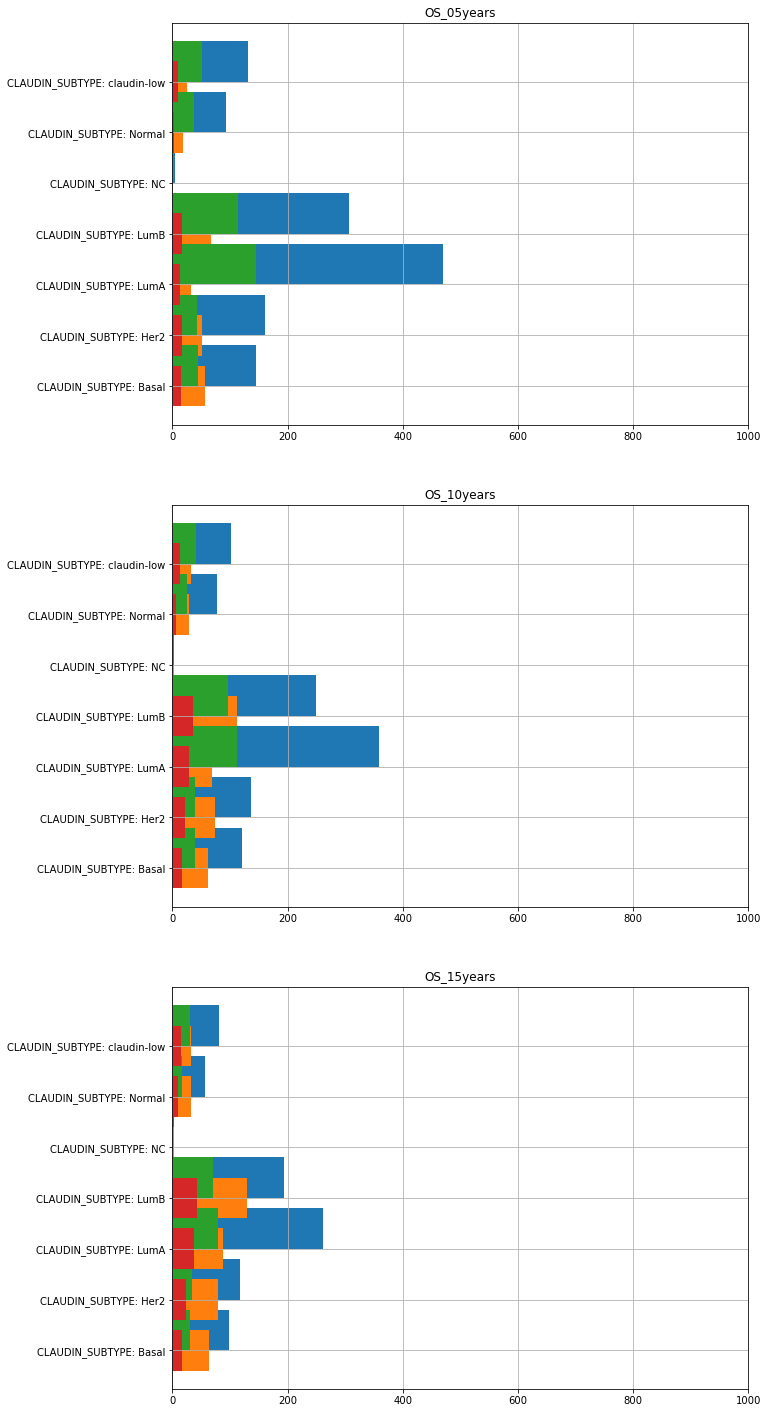

In [13]:
df_train, df_test = train_test_split(df_cross, random_state=SEED)

plt.figure(figsize=(20, 34))
plt.subplots_adjust(left=0.5)
funcs = ["count", "sum", "mean"]
for i, v in enumerate(target_list):
    # 各STATUSに属するサンプル数の可視化
    # df_tmp: 表示したい数のdf、df_tmp2: プロット時のクラス名前の付与
    # trai
    df_tmp = df_train.groupby("CLAUDIN_SUBTYPE")[v].agg(funcs).reset_index()
    df_tmp["gene_label"] = "CLAUDIN_SUBTYPE: " + df_tmp["CLAUDIN_SUBTYPE"]
    plt.subplot(len(target_list) + 1, 1, i + 1)
    plt.barh(y=df_tmp["gene_label"], width=df_tmp["count"], align="edge")

    # 各STAUSに属する目的変数の正例（乳がんによってn年の予後の死亡者数）の可視化
    # sumのカラムを指定しているが、これは目的変数が2値分類であるため、sumがtrueの総数を示している。
    plt.subplot(len(target_list) + 1, 1, i + 1)
    plt.barh(y=df_tmp["gene_label"], width=df_tmp["sum"])

    # test
    df_tmp = df_test.groupby("CLAUDIN_SUBTYPE")[v].agg(funcs).reset_index()
    df_tmp["gene_label"] = "CLAUDIN_SUBTYPE: " + df_tmp["CLAUDIN_SUBTYPE"]
    plt.subplot(len(target_list) + 1, 1, i + 1)
    plt.barh(y=df_tmp["gene_label"], width=df_tmp["count"], align="edge")
    plt.subplot(len(target_list) + 1, 1, i + 1)
    plt.barh(y=df_tmp["gene_label"], width=df_tmp["sum"])

    plt.title(v)
    plt.tight_layout = True
    plt.xlim(0, 1000)

    plt.grid(True)

大まかにはtrain,testのデータ量の比率は大丈夫そう

数の少ないNCについては確認

In [14]:
df_train[df_train["CLAUDIN_SUBTYPE"] == "NC"]

,OS_05years,OS_10years,OS_15years,CLAUDIN_SUBTYPE,RERE,RNF165,CD049690,BC033982,PHF7,CIDEA,PAPD4,AI082173,SLC17A3,SDS,ATP6V1C2,F3,FAM71C,AK055082,BU687559,LIN52,PCOTH,GRM1,FXN,SLC9A1,PML,...,TMEM146,SLIT3-AS1,PSMC3IP,TEAD1,LOC253724,BM725158,GRHPR,EGLN2,TBC1D4,ANGPTL2,AF086457,AK124197,ENOX1,SBF2-AS1,VN1R4,BX115874,BX107598,UGCGL1,VPS72,CSMD3,CC2D1A,CB986545,IGSF9,DA110839,FAM71A
803,False,True,True,NC,9.232775,5.684506,5.549272,5.229785,7.135959,5.574847,7.239234,5.610583,5.712039,6.555837,5.380589,5.891009,5.403241,5.611992,5.493431,5.640751,5.378960,5.457948,6.668552,9.834888,8.687667,...,4.942155,5.402007,5.257030,5.632073,5.576194,5.146395,7.829231,12.330379,6.489781,7.253072,5.183949,7.282830,6.313969,5.444530,5.798916,5.489539,5.430857,9.266545,7.986918,5.447164,7.244882,5.219696,6.251790,5.395806,5.495293
1858,True,True,True,NC,9.145344,5.693430,5.247809,5.487468,5.905418,9.682270,8.241262,5.173806,5.600204,6.402999,5.499857,5.848234,5.469991,5.622124,5.282562,6.466090,6.157855,5.263349,6.039950,8.973335,7.295681,...,5.210486,5.404015,6.661604,5.380589,5.665482,5.318350,8.456725,10.538381,6.419921,9.818465,5.604104,5.696594,5.625684,5.416062,5.543376,5.231852,5.288600,7.427494,8.140274,5.242993,5.957265,5.430206,6.500926,5.314402,5.102854
926,False,NaN,NaN,NC,9.375749,6.805984,5.512144,5.203031,6.006168,9.925118,9.003693,5.230243,5.675869,6.563520,5.196793,6.444020,5.495824,5.450528,5.594094,6.136965,5.739226,5.175794,6.030502,9.535611,7.263929,...,5.152642,5.471858,5.924224,5.223516,5.336431,5.275628,8.104001,11.076031,6.758905,8.953343,5.627411,5.998360,5.489234,5.500631,5.444427,5.290177,5.331632,7.803960,7.913550,5.230487,6.400798,5.347453,6.515638,5.450356,4.948689
533,False,False,False,NC,8.746475,6.236368,5.190039,5.370501,5.879293,5.603518,8.365536,5.399194,5.519185,6.067197,5.385871,6.609433,5.334152,5.520260,5.255074,6.152495,6.090777,5.256276,6.038869,9.334087,6.212881,...,5.232662,5.222655,6.505239,5.488750,5.405459,5.342856,8.153666,10.219242,6.506232,9.630245,5.202284,5.669465,5.722818,5.510159,5.347605,5.589518,5.556605,7.464064,8.399333,5.248618,5.851315,5.371495,7.762986,5.306048,5.454326


In [15]:
df_test[df_test["CLAUDIN_SUBTYPE"] == "NC"]

,OS_05years,OS_10years,OS_15years,CLAUDIN_SUBTYPE,RERE,RNF165,CD049690,BC033982,PHF7,CIDEA,PAPD4,AI082173,SLC17A3,SDS,ATP6V1C2,F3,FAM71C,AK055082,BU687559,LIN52,PCOTH,GRM1,FXN,SLC9A1,PML,...,TMEM146,SLIT3-AS1,PSMC3IP,TEAD1,LOC253724,BM725158,GRHPR,EGLN2,TBC1D4,ANGPTL2,AF086457,AK124197,ENOX1,SBF2-AS1,VN1R4,BX115874,BX107598,UGCGL1,VPS72,CSMD3,CC2D1A,CB986545,IGSF9,DA110839,FAM71A
1302,False,False,False,NC,9.540285,6.874232,5.256893,5.380006,6.012681,5.924414,8.091861,5.256086,5.625752,6.710375,5.396173,5.624752,5.318313,5.460340,5.245090,5.539649,7.104079,5.352159,6.606179,10.419544,6.864178,...,5.068038,5.473636,5.784465,5.591020,5.631688,5.474550,8.127024,10.960146,6.730685,9.577290,5.662672,5.631670,5.618781,5.463764,5.523588,5.528654,5.327963,7.088676,8.287344,5.390791,6.708604,5.421290,7.181684,5.423229,5.330702
1542,False,False,NaN,NC,9.260052,6.762604,5.332223,5.351526,6.388192,8.587925,7.481390,5.454708,5.603289,6.255192,5.316599,5.715155,5.469240,5.489841,5.175385,5.924962,5.788998,7.624685,6.360152,9.916234,7.931711,...,5.275678,5.320989,5.827177,5.707003,5.981490,5.318664,7.784967,11.685759,6.356845,7.962407,5.267513,6.051745,5.197040,5.257659,5.481906,5.803853,5.581225,8.162512,7.521205,6.156114,6.088364,5.319071,6.655234,5.234130,5.039263


testデータにはFalseの事例しか無く、また、交差検証をする際に十分に学習できる見込みがない  
▷NCのデータも削除したほうが良い

In [16]:
# CLAUDIN_SUBTYPE==NCの削除
df_cross = df_cross[df_cross["CLAUDIN_SUBTYPE"] != "NC"]
# save
make_dir(config.INTERIM_PICKLE_PREPROCESSED_PROGNOSIS_CROSS_DIR)
df_cross.to_pickle(
    config.INTERIM_PICKLE_PREPROCESSED_PROGNOSIS_CROSS_DIR + "/df_cross.pkl"
)

In [17]:
df_train, df_test = train_test_split(df_cross, random_state=SEED)
X_dict, y_dict = {}, {}

In [18]:
# データが複数種類あるので、辞書に保存する
X_dict["basic"] = {"train": dict(), "test": dict()}
y_dict["basic"] = {"train": dict(), "test": dict()}

dir_name = config.INTERIM_PICKLE_PREPROCESSED_PROGNOSIS_CROSS_DIR + "/basic"
make_dir(dir_name + "/train")
make_dir(dir_name + "/test")

for year in tqdm(range(5, 16, 5)):  # 予後年数毎のループ（5,10,15年）

    # ループ内定数の初期化
    prognosis_column = "OS_{0:0=2}years".format(year)
    drop_columns = ["CLAUDIN_SUBTYPE", "OS_05years", "OS_10years", "OS_15years"]

    # print("-----" * 15)
    # 説明変数、目的変数の定義
    X_train_tmp = df_train[df_train[prognosis_column].notnull()].drop(
        drop_columns, axis=1
    )
    y_train_tmp = df_train[prognosis_column].dropna().astype(int)
    X_test_tmp = df_test[df_test[prognosis_column].notnull()].drop(drop_columns, axis=1)
    y_test_tmp = df_test[prognosis_column].dropna().astype(int)
    # サンプルサイズのユニットテスト
    # print(X_train_tmp.shape[0] , y_train_tmp.shape[0])
    assert (
        X_train_tmp.shape[0] == y_train_tmp.shape[0]
    ), "train sample size is incorrect"
    assert X_test_tmp.shape[0] == y_test_tmp.shape[0], "test sample size is incorrect"
    # print(X_test_tmp.shape[0] , y_test_tmp.shape[0])

    # 辞書に格納
    X_dict["basic"]["train"]["X{0:0=2}".format(year)] = X_train_tmp
    y_dict["basic"]["train"]["y{0:0=2}".format(year)] = y_train_tmp
    X_dict["basic"]["test"]["X{0:0=2}".format(year)] = X_test_tmp
    y_dict["basic"]["test"]["y{0:0=2}".format(year)] = y_test_tmp

    # データの保存
    X_train_tmp.to_pickle(dir_name + "/train/X{0:0=2}.pickle".format(year))
    y_train_tmp.to_pickle(dir_name + "/train/y{0:0=2}.pickle".format(year))
    y_test_tmp.to_pickle(dir_name + "/test/y{0:0=2}.pickle".format(year))
    X_test_tmp.to_pickle(dir_name + "/test/X{0:0=2}.pickle".format(year))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.42it/s]


## サンプル全体に対してchi2検定を実施     

In [23]:
X_dict["chi2"] = {"train": dict(), "test": dict()}
y_dict["chi2"] = {"train": dict(), "test": dict()}

dir_name = config.INTERIM_PICKLE_PREPROCESSED_PROGNOSIS_CROSS_DIR + "/chi2"
make_dir(dir_name + "/train")
make_dir(dir_name + "/test")

p = 0.1

for year in tqdm(range(5, 16, 5)):

    # ループ内定数の初期化
    # 単純に考えるために、初期化タイミングをforループ内としておく
    set_col_tmp = set()
    drop_columns = ["CLAUDIN_SUBTYPE", "OS_05years", "OS_10years", "OS_15years"]
    prognosis_column = "OS_{0:0=2}years".format(year)

    # print("-----" * 15)
    # 説明変数、目的変数の定義
    X_train_tmp = df_train[df_train[prognosis_column].notnull()].drop(
        drop_columns, axis=1
    )
    y_train_tmp = df_train[prognosis_column].dropna().astype(int)
    X_test_tmp = df_test[df_test[prognosis_column].notnull()].drop(drop_columns, axis=1)
    y_test_tmp = df_test[prognosis_column].dropna().astype(int)
    # サンプルサイズのユニットテスト
    assert (
        X_train_tmp.shape[0] == y_train_tmp.shape[0]
    ), "train sample size is incorrect"
    assert X_test_tmp.shape[0] == y_test_tmp.shape[0], "test sample size is incorrect"

    # 特徴量選択の実施（chi2）
    # set（集合）の構造化形式を用いて、各予後年数から選択された各特徴量を取得する（重複の回避）
    result_chi2 = feature_selection(X_train_tmp, y_train_tmp, chi2, "k_best", "all")
    for col in result_chi2[
        result_chi2.pvalue < p
    ].index:  # result_chi2はindexにcolumn_nameが記載されている
        set_col_tmp.add(col)

    # 特徴量選択で選ばれた特徴量の抽出（訓練、テストデータに適用）
    # list変換するのはfuture warningが出るため
    X_train_tmp = X_train_tmp[list(set_col_tmp)]
    X_test_tmp = X_test_tmp[list(set_col_tmp)]

    # 辞書に格納
    X_dict["chi2"]["train"]["X{0:0=2}".format(year)] = X_train_tmp
    y_dict["chi2"]["train"]["y{0:0=2}".format(year)] = y_train_tmp
    X_dict["chi2"]["test"]["X{0:0=2}".format(year)] = X_test_tmp
    y_dict["chi2"]["test"]["y{0:0=2}".format(year)] = y_test_tmp

    # データの保存
    X_train_tmp.to_pickle(dir_name + "/train/X{0:0=2}.pickle".format(year))
    y_train_tmp.to_pickle(dir_name + "/train/y{0:0=2}.pickle".format(year))
    y_test_tmp.to_pickle(dir_name + "/test/y{0:0=2}.pickle".format(year))
    X_test_tmp.to_pickle(dir_name + "/test/X{0:0=2}.pickle".format(year))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.57it/s]


## CLAUDIN_SUBTYPE毎にchi2検定に基づく特徴量選択の実施

trainデータとtestデータを混ぜて特徴量選択すると良くない

In [24]:
X_dict["chi2"]["claudin_subtype"] = {"train": dict(), "test": dict()}
y_dict["chi2"]["claudin_subtype"] = {"train": dict(), "test": dict()}

dir_name = (
    config.INTERIM_PICKLE_PREPROCESSED_PROGNOSIS_CROSS_DIR + "/chi2/claudin_subtype"
)
make_dir(dir_name + "/train")
make_dir(dir_name + "/test")

p = 0.1
subtype_dic = {}

for st in tqdm(df_train["CLAUDIN_SUBTYPE"].unique()):  # 遺伝子サブタイプ毎のループ
    for year in range(5, 16, 5):  # 予後年数毎のループ

        # ループ内定数の初期化
        # 単純に考えるために、初期化タイミングをforループ内としておく
        set_col_tmp = set()
        drop_columns = ["CLAUDIN_SUBTYPE", "OS_05years", "OS_10years", "OS_15years"]
        prognosis_column = "OS_{0:0=2}years".format(year)

        # print("-----" * 15)
        # 説明変数、目的変数の定義
        X_train_tmp = df_train[
            (df_train["CLAUDIN_SUBTYPE"] == st) & (df_train[prognosis_column].notnull())
        ].drop(drop_columns, axis=1)
        y_train_tmp = (
            df_train[df_train["CLAUDIN_SUBTYPE"] == st][prognosis_column]
            .dropna()
            .astype(int)
        )
        X_test_tmp = df_test[
            (df_test["CLAUDIN_SUBTYPE"] == st) & (df_test[prognosis_column].notnull())
        ].drop(drop_columns, axis=1)
        y_test_tmp = (
            df_test[df_test["CLAUDIN_SUBTYPE"] == st][prognosis_column]
            .dropna()
            .astype(int)
        )
        # サンプルサイズのユニットテスト
        # print(X_train_tmp.shape[0], y_train_tmp.shape[0])
        assert (
            X_train_tmp.shape[0] == y_train_tmp.shape[0]
        ), "train sample size is incorrect"
        assert (
            X_test_tmp.shape[0] == y_test_tmp.shape[0]
        ), "test sample size is incorrect"

        # 特徴量選択の実施（chi2）
        # set（集合）の構造化形式を用いて、各予後年数から選択された各特徴量を取得する（重複の回避）
        result_chi2 = feature_selection(X_train_tmp, y_train_tmp, chi2, "k_best", "all")
        for col in result_chi2[
            result_chi2.pvalue < p
        ].index:  # result_chi2はindexにcolumn_nameが記載されている
            set_col_tmp.add(col)

        # 特徴量選択で選ばれた特徴量の抽出（訓練、テストデータに適用）
        # list変換するのはfuture warningが出るため
        X_train_tmp = X_train_tmp[list(set_col_tmp)]
        X_test_tmp = X_test_tmp[list(set_col_tmp)]

        # 辞書に格納
        X_dict["chi2"]["claudin_subtype"]["train"][
            "X{0:0=2}_{1}".format(year, st)
        ] = X_train_tmp
        y_dict["chi2"]["claudin_subtype"]["train"][
            "y{0:0=2}_{1}".format(year, st)
        ] = y_train_tmp
        X_dict["chi2"]["claudin_subtype"]["test"][
            "X{0:0=2}_{1}".format(year, st)
        ] = X_test_tmp
        y_dict["chi2"]["claudin_subtype"]["test"][
            "y{0:0=2}_{1}".format(year, st)
        ] = y_test_tmp

        # データの保存
        X_train_tmp.to_pickle(dir_name + "/train/X{0:0=2}_{1}.pickle".format(year, st))
        y_train_tmp.to_pickle(dir_name + "/train/y{0:0=2}_{1}.pickle".format(year, st))
        y_test_tmp.to_pickle(dir_name + "/test/y{0:0=2}_{1}.pickle".format(year, st))
        X_test_tmp.to_pickle(dir_name + "/test/X{0:0=2}_{1}.pickle".format(year, st))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.61it/s]


# 特徴量選択（wrapper methods）

## Borutaによる特徴量選択

### 全特徴量を同時に扱う場合

In [25]:
X_dict["chi2"]["boruta"] = {"train": dict(), "test": dict()}
y_dict["chi2"]["boruta"] = {"train": dict(), "test": dict()}


dir_name = config.INTERIM_PICKLE_PREPROCESSED_PROGNOSIS_CROSS_DIR + "/chi2/boruta"
make_dir(dir_name + "/train")
make_dir(dir_name + "/test")

for year in range(5, 16, 5):  # 全部の特徴量で学習

    drop_columns = ["CLAUDIN_SUBTYPE", "OS_05years", "OS_10years", "OS_15years"]
    prognosis_column = "OS_{0:0=2}years".format(year)
    prognosis_Xlabel = "X{0}".format(str(year).zfill(2))
    prognosis_ylabel = "y{0}".format(str(year).zfill(2))
    print("----------" * 10)
    print(
        "特徴量選択前の特徴量数：",
        len(X_dict["chi2"]["train"][prognosis_Xlabel].columns),
    )

    # RandomForestClassifierでBorutaを実行
    rfc = RandomForestClassifier(n_jobs=-1, max_depth=5, random_state=SEED)
    feat_selector = BorutaPy(rfc, n_estimators="auto", verbose=0, random_state=SEED)
    feat_selector.fit(
        X_dict["chi2"]["train"][prognosis_Xlabel].values,
        y_dict["chi2"]["train"][prognosis_ylabel].values,
    )

    # 選択された特徴量を確認
    selected = feat_selector.support_
    print("選択された特徴量の数:{0}".format(np.sum(selected)))
    # print(selected)

    # 辞書に格納（yも同ラベルで保存しておく）
    # 選択された特徴量
    X_train_columns = sorted(
        X_dict["chi2"]["train"][prognosis_Xlabel][
            X_dict["chi2"]["train"][prognosis_Xlabel].columns[selected]
        ]
    )
    # 訓練データ
    X_dict["chi2"]["boruta"]["train"][prognosis_Xlabel] = X_dict["chi2"]["train"][
        prognosis_Xlabel
    ][X_train_columns]
    y_dict["chi2"]["boruta"]["train"][prognosis_ylabel] = y_dict["chi2"]["train"][
        prognosis_ylabel
    ]
    # テストデータ
    X_dict["chi2"]["boruta"]["test"][prognosis_Xlabel] = X_dict["chi2"]["test"][
        prognosis_Xlabel
    ][X_train_columns]
    y_dict["chi2"]["boruta"]["test"][prognosis_ylabel] = y_dict["chi2"]["test"][
        prognosis_ylabel
    ]

    # データの保存
    X_dict["chi2"]["boruta"]["train"][prognosis_Xlabel].to_pickle(
        dir_name + "/train/X{0:0=2}.pickle".format(year)
    )
    y_dict["chi2"]["boruta"]["train"][prognosis_ylabel].to_pickle(
        dir_name + "/train/y{0:0=2}.pickle".format(year)
    )
    X_dict["chi2"]["boruta"]["test"][prognosis_Xlabel].to_pickle(
        dir_name + "/test/X{0:0=2}.pickle".format(year)
    )
    y_dict["chi2"]["boruta"]["test"][prognosis_ylabel].to_pickle(
        dir_name + "/test/y{0:0=2}.pickle".format(year)
    )

----------------------------------------------------------------------------------------------------
特徴量選択前の特徴量数： 355
選択された特徴量の数:22
----------------------------------------------------------------------------------------------------
特徴量選択前の特徴量数： 195
選択された特徴量の数:38
----------------------------------------------------------------------------------------------------
特徴量選択前の特徴量数： 106
選択された特徴量の数:37
